In [1]:
#
# Import all the dependencies
#
import os
import keras
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from keras import layers, Input, Model
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from keras.layers import (GRU, Dense, Lambda, Masking, RepeatVector, TimeDistributed, concatenate)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
tf.config.run_functions_eagerly(True)

In [4]:
#
# Create '/latent_space_data' folder if it does not exist already
#
if not os.path.exists('/content/gdrive/My Drive/latent_space_data'):
    os.makedirs('/content/gdrive/My Drive/latent_space_data')
if not os.path.exists('/content/gdrive/My Drive/saved_models/vae_chck_pts'):
    os.makedirs('/content/gdrive/My Drive/saved_models/vae_chck_pts')
if not os.path.exists('/content/gdrive/My Drive/light_curve_plots'):
    os.makedirs('/content/gdrive/My Drive/light_curve_plots')

In [5]:
class CustomMasking(layers.Layer):
    def __init__(self, **kwargs):
        super(CustomMasking, self).__init__(name="CustomMasking", **kwargs)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        return inputs * mask


In [6]:
class Sampling(layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super(Sampling, self).__init__(name="Sampling", **kwargs)
        self.output_dim = output_dim
        self.supports_masking = True

    def call(self, inputs, mask=None):
        # print("Sampling Output:", inputs)
        z_mean, z_log_var = inputs
        batch = K.shape(z_mean)[0]
        dim = K.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        output = z_mean + K.exp(0.5 * z_log_var) * epsilon

        return output

In [7]:
class Encoder(keras.Model):
    def __init__(self, shapes, mask_val=0, name='encoder', **kwargs):
        # properties
        self.mask_val = mask_val
        self.shapes = shapes

        # call Model initializer
        super(Encoder, self).__init__(name=name, **kwargs)

        # define Encoder layers
        self.mask = Masking(mask_value=mask_val)

        # first recurrent layer
        self.gru1 = GRU(shapes['gru1'],
                        activation='tanh',
                        recurrent_activation='hard_sigmoid',
                        return_sequences=True,
                        name='gru1')
        # second recurrent layer
        self.encoded = GRU(
            shapes['gru2'],
            activation='tanh',
            recurrent_activation='hard_sigmoid',
            return_sequences=True,
            name='gru2')

        # z mean output
        self.z_mean = GRU(
            shapes['gru3'],
            return_sequences=False,
            activation='linear',
            name='gru3')

        # z variance output
        self.z_log_var = GRU(
            shapes['gru4'],
            return_sequences=False,
            activation='linear',
            name='gru4'
        )

        # sample output
        self.z = Sampling(shapes['gru4'])

    def get_config(self):
        return {"shapes": self.shapes, 'mask_val': 0, 'name': 'encoder'}

    # define forward pass
    def call(self, inputs):
        mask_tensor = self.mask(inputs)
        gru1 = self.gru1(mask_tensor)
        encoded = self.encoded(gru1)
        z_mean = self.z_mean(encoded)
        z_log_var = self.z_log_var(encoded)
        z = self.z([z_mean, z_log_var])

        return z_mean, z_log_var, z


In [8]:
class Decoder(keras.Model):
    def __init__(self, shapes, mask_val=0, name='decoder', **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.mask_val = mask_val
        self.shapes = shapes

        # define layers
        self.repeater = RepeatVector(shapes['repeater'], name='rep')

        self.custom_mask = CustomMasking()

        # first recurrent layer
        self.gru5 = GRU(
            shapes['gru5'],
            activation='tanh',
            recurrent_activation='hard_sigmoid',
            return_sequences=True,
            name='gru5')

        # second recurrent layer
        self.gru6 = GRU(
            shapes['gru6'],
            activation='tanh',
            recurrent_activation='hard_sigmoid',
            return_sequences=True,
            name='gru6')

        # decoder output
        self.dec_output = TimeDistributed(
            Dense(1, activation='tanh', input_shape=shapes['dec_output']),
            name='td')

    def get_config(self):
        config = {
            "shapes": self.shapes,
            'mask_val': 0,
            'name': 'decoder'}
        return config

    # define forward pass
    def call(self, inputs):
        z, train_input_two, masks, dec_masks = inputs
        # back at 200 numbs
        repeater = self.repeater(z)

        concat = concatenate([repeater, train_input_two], axis=-1)

        mask_tensor = self.custom_mask(concat, mask=masks)

        gru5 = self.gru5(mask_tensor, mask=None)

        gru6 = self.gru6(gru5)

        dec_output = self.dec_output(gru6)

        return self.custom_mask(dec_output, mask=dec_masks)


In [9]:
class VAE(keras.Model):
    def __init__(self, prepared_data, name='vae', **kwargs):
        super(VAE, self).__init__(name=name, **kwargs)
        self.epochs = 10
        self.batch_size = 64
        self.optimizer = 'adam'
        dims = np.asarray(prepared_data).shape

        # dimension of the latent vector
        self.latent_dim = 30

        # input to first encoder and second decoder layer
        self.gru_one = 175

        # input to first decoder and second encoder layer
        self.gru_two = 150

        # load prepared dad (acts a input)
        self.prepared_data = np.array(prepared_data)

        # number of input features
        self.num_feats = dims[2]

        # number of timesteps
        self.num_timesteps = dims[1]

        # dimension of the input space for encoder
        self.enc_input_shape = (self.num_timesteps, self.num_feats)

        # number of light curves
        self.num_lcs = dims[0]

        # layer dimensions for encoder and decoder, respectively
        self.enc_dims = {
            'enc_input': self.enc_input_shape,
            'gru1': self.gru_one,
            'gru2': self.gru_two,
            'gru3': self.latent_dim,
            'gru4': self.latent_dim
        }
        self.dec_dims = {
            'dec_input': self.latent_dim,
            'repeater': self.num_timesteps,
            'input_two': (self.num_timesteps, 2),
            'gru5': self.gru_two,
            'gru6': self.gru_one,
            'dec_output': (None, 1)
        }

        # indxs for test and train
        self.train_indx = set()
        self.test_indx = set()

        self.mask_value = 0.0

        self.encoder = Encoder(self.enc_dims)
        self.decoder = Decoder(self.dec_dims)

    def get_config(self):
        config = {"prepared_data": np.array(self.prepared_data), 'name': 'vae'}
        return config

    # define forward pass
    def call(self, inputs):
        x_train, train_input_two, masks, dec_masks = inputs
        z_mean, z_log_var, z = self.encoder(x_train)
        # encoded_data = z_mean.numpy()
        #
        # Store the file in -- '/latent_space_data/{type}/' folder
        #
        #print(type(encoded_data))
        # with open(f"/content/gdrive/My Drive/latent_space_data/vae_data.pickle", 'wb') as file:
        #     pickle.dump(encoded_data, file)
        
        reconstructed = self.decoder([z, train_input_two, masks, dec_masks])

        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

    def reconstruction_loss(self, yTrue, yPred):
        return K.log(K.mean(K.square(yTrue - yPred)))

    def split_training_data(self):
        """
        Splits data into 3/4 training, 1/4 testing
        """

        print("Splitting data into train and test...")

        # prepared out (only flux)
        prep_out = self.prepared_data[:, :, 2].reshape(
            self.num_lcs, self.num_timesteps, 1)
        prep_inp = self.prepared_data

        x_train = []
        y_train = []
        x_test = []
        y_test = []

        # calc the # of light curves for train vs test
        num_lcs = len(prep_inp)
        train_perc = round(1.0 * num_lcs)
        test_perc = round(num_lcs * 0.2)

        # save random indices for training
        while len(self.train_indx) != train_perc:
            indx = random.randint(0, num_lcs - 1)
            self.train_indx.add(indx)

        # save random indices for testint -> no duplicates from training
        while len(self.test_indx) <= test_perc:
            indx = random.randint(0, num_lcs - 1)
            # if indx not in self.train_indx:
            self.test_indx.add(indx)

        # extract training data
        for ind in self.train_indx:
            x_train.append(prep_inp[ind])
            y_train.append(prep_out[ind])

        # extract testing data
        for ind in self.test_indx:
            x_test.append(prep_inp[ind])
            y_test.append(prep_out[ind])

        # change to numpy arrays
        x_train = np.array(x_train).astype(np.float64)
        x_test = np.array(x_test).astype(np.float64)
        y_train = np.array(y_train).astype(np.float64)
        y_test = np.array(y_test).astype(np.float64)

        print('shape of prep_inp and x_train:', prep_inp.shape, x_train.shape)
        print('shape of prep_out and y_train:', prep_out.shape, y_train.shape)

        return x_train, x_test, y_train, y_test, prep_inp, prep_out

    def compute_masks(self, x_train, size):
        masks = []
        for light_curve in x_train:
            mask = []
            for (time, band, flux, error) in light_curve:
                if band == 0:
                    mask.append([0.0] * (size))
                else:
                    mask.append([1.0] * (size))
            masks.append(mask)

        return np.array(masks)

    def train_model(self, x_train, x_test, y_train, y_test):
        """
        Trains the NN on training data

        Returns the trained model.
        """
        # fit model
        train_inp_two = x_train[:, :, :2]
        assert (train_inp_two.shape == (x_train.shape[0], x_train.shape[1], 2))

        test_inp_two = x_test[:, :, :2]
        assert (test_inp_two.shape == (x_test.shape[0], x_test.shape[1], 2))

        train_masks = self.compute_masks(x_train, self.latent_dim + 2)
        test_masks = self.compute_masks(x_test, self.latent_dim + 2)

        train_dec_output_masks = self.compute_masks(x_train, 1)
        test_dec_output_masks = self.compute_masks(x_test, 1)

        print('fitting model...')
        history = self.fit([x_train, train_inp_two, train_masks, train_dec_output_masks],
                           y_train, epochs=self.epochs, batch_size=self.batch_size,
                           validation_data=([x_test, test_inp_two, test_masks, test_dec_output_masks], y_test),
                           verbose=1, shuffle=False)

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

    def test_model(self, x_test, y_test, amount=None):
        """
        Uses test data to and NN to predict light curve decodings.

        Plots reconstructed light curved from the model prediction vs the orignal curve.
        """
        if amount:
            indices = random.sample(range(len(x_test)), k=amount)
            x_test = np.array([x_test[i] for i in indices])
            y_test = np.array([y_test[i] for i in indices])

        test_inp_two = x_test[:, :, [0, 3]]

        print('test_inp_one shape: ', x_test.shape)
        print('test_inp_two shape: ', test_inp_two.shape)

        self.summary()
        #
        # Create array to store the encoded flux
        #
        encoded_flux = np.zeros((len(x_test), len(x_test[0])))
        print(f"\nencoded flux shape:", encoded_flux.shape)
        print('predicting...')


        for i in tqdm(range(len(x_test))):

            # predicted flux
            predicted = self.predict([x_test[i].reshape(-1, self.num_timesteps, 4),
                                      test_inp_two[i].reshape(-1, self.num_timesteps, 2),
                                      # train_masks
                                      self.compute_masks(x_test[i].reshape(-1, self.num_timesteps, 4),
                                                         self.latent_dim + 2),
                                      # train output masks
                                      self.compute_masks(x_test[i].reshape(-1, self.num_timesteps, 4), 1)
                                      ])[0]
            print("\n After self.predict() --> ",predicted.shape,"\n", type(predicted),"\n")
            encoded_flux[i] = predicted.T
            print(f"\nencoded flux shape:", encoded_flux.shape)
            # if first prediction, print the prediction
            if i == 0:
                print('shape of predicted data: ', predicted.shape)

            self.plot_band_pred(y_test[i], predicted, i, test_inp_two[i])

        print("done predicting")
        #
        # Store the file in -- '/latent_space_data/{type}/' folder
        #
        
        with open(f"/content/gdrive/My Drive/latent_space_data/vae_data.pickle", 'wb') as file:
            pickle.dump(encoded_flux, file)

    def plot_band_pred(self, raw, pred, num, time_filters):
        # print("\nflux shape", raw.shape, "\n",pred.shape, "\n", raw, "\n", pred)
        # print()
        raw_g_flux = []
        raw_r_flux = []
        raw_tess_flux = []

        pred_g_flux = []
        pred_r_flux = []
        pred_tess_flux = []

        g_time = []
        r_time = []
        tess_time = []
        # print("\n time_filter --->", time_filters)
        for i in range(len(time_filters)):
            time, filter_ID = time_filters[i]
            raw_flux = raw[i, 0]
            pred_flux = pred[i, 0]
            if filter_ID == 4.716:
                raw_g_flux.append(raw_flux)
                pred_g_flux.append(pred_flux)
                g_time.append(time)
            elif filter_ID == 6.215:
                raw_r_flux.append(raw_flux)
                pred_r_flux.append(pred_flux)
                r_time.append(time)
            elif filter_ID == 7.865:
                raw_tess_flux.append(raw_flux)
                pred_tess_flux.append(pred_flux)
                tess_time.append(time)

        # plot
        # make 1 x 2 figure
        fig, (ax1, ax2) = plt.subplots(2, sharey=True)
        fig.suptitle('True vs Decoded Light Curves: ')  # + str(light_curve_names[num]))

        # pred_time = range(len(pred_flux))
        # raw_time = range(len(raw_flux))

        # plot raw data
        ax1.scatter(g_time, raw_g_flux, label='g-band', color='green')
        ax1.scatter(r_time, raw_r_flux, label='r-band', color='red')
        ax1.scatter(tess_time, raw_tess_flux, label='tess-band')
        ax1.set_ylabel('actual')

        # plot predicted data
        ax2.set_ylabel('predicted')
        ax2.scatter(g_time, pred_g_flux, label='g-band', color='green')
        ax2.scatter(r_time, pred_r_flux, label='r-band', color='red')
        ax2.scatter(tess_time, pred_tess_flux, label='tess-band')
        # save image
        #fig.show()
        fig.savefig("/content/gdrive/My Drive/light_curve_plots/" + str(num) + ".png")

    def save_latent_space(self, X_in):
        latent_space = vae.encoder(X_in)

        with open(f"../latent_space_data/vae_latent_space.pickle", 'wb') as file:
            pickle.dump(latent_space, file)

        return latent_space

In [10]:
class GenerateData(object):

    def __init__(self, lc_type=None, passbands=["r", "g"], path=None, metadata=None):

        """
        Generates data for Variational Auto-Encoder

        Parameters
        ----------
        lc_type: string
            type of light curves (transits or transients)

        n_filters: int (default =1)
            number of filters for the PLAsTiCC light curves

        path: string
            the file location of the light curves

        """

        self.type = lc_type
        self.path = path
        self.labels = None
        self.passbands = passbands
        self.metadata = metadata

        try:
            if self.type not in ["transits", "transients"]:
                raise ValueError(f"\nValueError: '{self.type}' is not a valid type!"
                                 f"\nPlease provide the type as - 'transits' or 'transients'.")

            if self.type == "transits":
                raise NotImplementedError(f"\nNotImplementedError: Please specify the -- type -- as 'transients'!\n"
                                          f"'{self.type}' is not implemented yet!\n")
        except Exception as e:
            print(e)
            exit()

        try:

            if self.metadata:
                for i in self.metadata:
                    if i not in ["max_flux", "mwebv", "redshift"]:
                        raise ValueError(f"\nValueError: '{i}' is an invalid metadata!"
                                         f"\nPlease provide parameters as - 'max_flux' for maximum flux, 'mwebv' "
                                         f"for Milky Way extinction, and 'redshift'.")
        except Exception as e:
            print(e)
            exit()

        try:

            for i in self.passbands:
                if i not in ["r", "g"]:
                    raise ValueError(f"\nValueError: '{i}' is an invalid passband!"
                                     f"\nPlease provide passbands as - 'r' for PLAsTiCC r-band, 'g' for PLAsTiCC g-band.")
        except Exception as e:
            print(e)
            exit()

    def generate_data(self):
        
        curve_range = (-30, 70)
        band_flux = dict()
        label, columns = list(), list()
        filename = os.listdir(self.path)
        col_to_drop = ["redshift", "mwebv", "max_flux"]
        passbands_metadata = {"r": 6.215, "g": 4.716}
        maskval, interval_val, n_bands = 0.0, 3.0, len(self.passbands)
        timesteps = int(((curve_range[1] - curve_range[0]) / interval_val + 1) * n_bands)

        if self.metadata:
            n_cols = 4 + len(self.metadata)
            col_to_drop = list(set(col_to_drop) - set(self.metadata))
        else:
            n_cols = 4

        passband_values = {i: passbands_metadata[i] for i in self.passbands}

        x_train = np.zeros(shape=(len(filename), timesteps, n_cols))
        r_flux = np.zeros(shape=(len(filename), int(timesteps / n_bands)))
        g_flux = np.zeros(shape=(len(filename), int(timesteps / n_bands)))

        for i, csv in enumerate(filename):
            #
            # Object_ids  for the PLAsTiCC data set
            #
            id = os.path.splitext(csv)
            #
            label.append(id[0])
            df = pd.read_csv(self.path + csv)
            df.index = df["relative_time"]
            df = df.fillna(maskval)

            combined_df = pd.DataFrame()

            for pb, id in passband_values.items():

                pb_df = df[["relative_time", "mwebv", "redshift"]].copy()
                pb_df["uncert"] = df[f"{pb}_uncert"]
                pb_df["flux"] = df[f"{pb}_flux"]
                pb_df["id"] = id
                pb_df[(pb_df["flux"] == maskval) & (pb_df["uncert"] == maskval)] = maskval

                for t in np.arange(curve_range[0], curve_range[1], interval_val):
                    if t not in pb_df["relative_time"]:
                        pb_df.loc[t] = np.full(shape=len(pb_df.columns), fill_value=maskval)
                        pb_df = pb_df.sort_index()
                pb_df["max_flux"] = np.full(shape=len(pb_df), fill_value=max(pb_df["flux"]))
                pb_df[(pb_df["relative_time"] == maskval)] = maskval

                if pb == "g":
                    g_flux[i] = pb_df["flux"].values
                elif pb == "r":
                    r_flux[i] = pb_df["flux"].values

                combined_df = pd.concat([pb_df, combined_df])

            if col_to_drop:
                combined_df = combined_df.drop(columns=col_to_drop)

            x_train[i] = combined_df.sort_index().to_numpy()

        query_cols = ['relative_time', 'id']
        #
        # It holds the index value of the query columns - time and id
        #
        cols_index = [combined_df.columns.get_loc(col) for col in query_cols]
        #
        # It holds the index value of the flux column
        #
        flux_index = combined_df.columns.get_loc("flux")
        self.labels = label
        band_flux["r"], band_flux["g"] = r_flux, g_flux
        return x_train, cols_index, flux_index, self.labels, band_flux

    def save_data(self):
        #
        # Load the VAE transformed data and add metadata to the file
        #
        try:
            with open(f"../latent_space_data/transients/vae.pickle", 'rb') as file:
                data_ = pickle.load(file)
            data = {'data': data_, 'labels': self.labels}
            #
            # Store the file in -- '/latent_space_data/{type}/' folder
            #
            with open(f"../latent_space_data/{self.type}/vae.pickle", 'wb') as file:
                pickle.dump(data, file)

        except Exception as e:
            print(f"\nUnknownError: {e}\n")
            return
        #
        #
        #
        print(f"\nVAE latent space data is extracted and stored "
              f"in -- /latent_space_data/{self.type} -- folder!\n")

Splitting data into train and test...
shape of prep_inp and x_train: (5700, 68, 4) (5700, 68, 4)
shape of prep_out and y_train: (5700, 68, 1) (5700, 68, 1)
fitting model...
Epoch 1/3


/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


90/90 [==============================] - 393s 4s/step - loss: 15.1826 - val_loss: 15.5219
Epoch 2/3
90/90 [==============================] - 405s 5s/step - loss: 15.1628 - val_loss: 15.5201
Epoch 3/3
90/90 [==============================] - 409s 5s/step - loss: 15.1621 - val_loss: 15.5199


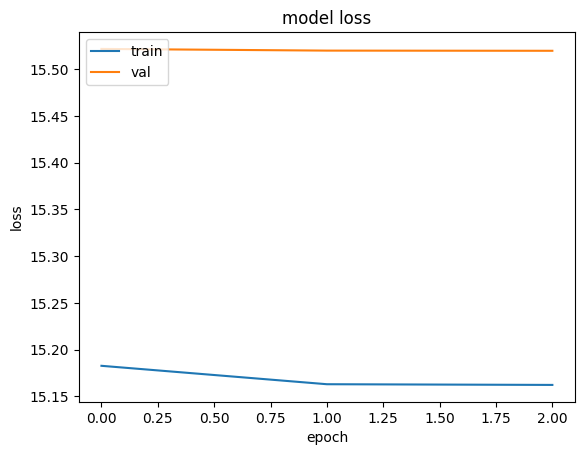

test_inp_one shape:  (5700, 68, 4)
test_inp_two shape:  (5700, 68, 2)
Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  274935    
                                                                 
 decoder (Decoder)           multiple                  254651    
                                                                 
Total params: 529,586
Trainable params: 529,586
Non-trainable params: 0
_________________________________________________________________

encoded flux shape: (5700, 68)
predicting...


  0%|          | 0/5700 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


  0%|          | 1/5700 [00:01<2:08:53,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
shape of predicted data:  (68, 1)
1/1 [==============================] - 1s 1s/step


  0%|          | 2/5700 [00:02<2:08:45,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 3/5700 [00:03<2:00:52,  1.27s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 4/5700 [00:05<1:57:13,  1.23s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 5/5700 [00:06<1:56:02,  1.22s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  0%|          | 6/5700 [00:08<2:42:18,  1.71s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 7/5700 [00:10<2:33:28,  1.62s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 8/5700 [00:11<2:19:52,  1.47s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 9/5700 [00:12<2:10:29,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 10/5700 [00:14<2:09:23,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 11/5700 [00:15<2:08:36,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 12/5700 [00:16<2:08:16,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 13/5700 [00:17<2:02:26,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 14/5700 [00:19<1:58:43,  1.25s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 15/5700 [00:20<2:01:49,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  0%|          | 16/5700 [00:23<2:40:54,  1.70s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 17/5700 [00:24<2:31:27,  1.60s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 18/5700 [00:25<2:24:20,  1.52s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 19/5700 [00:27<2:18:55,  1.47s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 20/5700 [00:28<2:09:54,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 21/5700 [00:29<2:04:38,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 22/5700 [00:30<2:00:24,  1.27s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 23/5700 [00:31<2:02:03,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 24/5700 [00:33<2:03:24,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  0%|          | 25/5700 [00:35<2:41:33,  1.71s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 26/5700 [00:37<2:32:40,  1.61s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 27/5700 [00:38<2:20:30,  1.49s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  0%|          | 28/5700 [00:39<2:12:04,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 29/5700 [00:40<2:05:23,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 30/5700 [00:42<2:05:41,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 31/5700 [00:43<2:01:31,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 32/5700 [00:44<2:02:56,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 33/5700 [00:46<2:04:03,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 34/5700 [00:47<2:06:56,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  1%|          | 35/5700 [00:49<2:14:05,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  1%|          | 36/5700 [00:50<2:19:28,  1.48s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 37/5700 [00:51<2:10:22,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 38/5700 [00:53<2:09:10,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 39/5700 [00:54<2:08:12,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 40/5700 [00:55<2:03:19,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 41/5700 [00:57<2:04:08,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 42/5700 [00:58<2:00:18,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 43/5700 [00:59<2:02:11,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 44/5700 [01:00<2:00:38,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  1%|          | 45/5700 [01:03<2:39:16,  1.69s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 46/5700 [01:06<3:06:34,  1.98s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 47/5700 [01:07<2:46:03,  1.76s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 48/5700 [01:08<2:31:43,  1.61s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 49/5700 [01:09<2:21:47,  1.51s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 50/5700 [01:11<2:17:25,  1.46s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 51/5700 [01:12<2:11:43,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 52/5700 [01:13<2:07:31,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  1%|          | 53/5700 [01:16<2:43:06,  1.73s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  1%|          | 54/5700 [01:18<3:09:06,  2.01s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 55/5700 [01:20<2:48:32,  1.79s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 56/5700 [01:21<2:35:43,  1.66s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 57/5700 [01:22<2:24:52,  1.54s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 58/5700 [01:24<2:19:07,  1.48s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 59/5700 [01:25<2:13:27,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 60/5700 [01:26<2:09:35,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 61/5700 [01:28<2:12:39,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  1%|          | 62/5700 [01:30<2:47:46,  1.79s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 63/5700 [01:32<2:35:31,  1.66s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 64/5700 [01:33<2:22:50,  1.52s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 65/5700 [01:34<2:15:22,  1.44s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 66/5700 [01:35<2:09:07,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 67/5700 [01:37<2:07:59,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 68/5700 [01:38<2:07:18,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 69/5700 [01:39<2:03:36,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|          | 70/5700 [01:41<2:04:05,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  1%|          | 71/5700 [01:43<2:41:33,  1.72s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|▏         | 72/5700 [01:46<3:07:48,  2.00s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|▏         | 73/5700 [01:47<2:49:06,  1.80s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|▏         | 74/5700 [01:49<2:32:31,  1.63s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|▏         | 75/5700 [01:50<2:22:54,  1.52s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|▏         | 76/5700 [01:51<2:17:51,  1.47s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|▏         | 77/5700 [01:53<2:14:06,  1.43s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|▏         | 78/5700 [01:54<2:11:36,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  1%|▏         | 79/5700 [01:57<2:45:51,  1.77s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  1%|▏         | 80/5700 [01:58<2:42:31,  1.74s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|▏         | 81/5700 [01:59<2:30:46,  1.61s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|▏         | 82/5700 [02:01<2:23:17,  1.53s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|▏         | 83/5700 [02:02<2:18:02,  1.47s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|▏         | 84/5700 [02:03<2:11:49,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  1%|▏         | 85/5700 [02:05<2:06:28,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 86/5700 [02:06<2:03:44,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 87/5700 [02:07<2:02:41,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  2%|▏         | 88/5700 [02:10<2:39:41,  1.71s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  2%|▏         | 89/5700 [02:12<2:41:25,  1.73s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 90/5700 [02:13<2:30:33,  1.61s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 91/5700 [02:14<2:24:47,  1.55s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 92/5700 [02:16<2:18:20,  1.48s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 93/5700 [02:17<2:14:17,  1.44s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 94/5700 [02:18<2:09:09,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 95/5700 [02:20<2:07:49,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 96/5700 [02:22<2:43:29,  1.75s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  2%|▏         | 97/5700 [02:25<3:09:02,  2.02s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 98/5700 [02:26<2:49:58,  1.82s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 99/5700 [02:28<2:36:31,  1.68s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 100/5700 [02:29<2:25:49,  1.56s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 101/5700 [02:30<2:18:28,  1.48s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 102/5700 [02:31<2:11:55,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 103/5700 [02:34<2:45:38,  1.78s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  2%|▏         | 104/5700 [02:37<3:09:19,  2.03s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  2%|▏         | 105/5700 [02:39<3:26:44,  2.22s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 106/5700 [02:41<3:00:45,  1.94s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 107/5700 [02:42<2:44:16,  1.76s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 108/5700 [02:43<2:33:09,  1.64s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 109/5700 [02:46<3:00:30,  1.94s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 110/5700 [02:49<3:19:39,  2.14s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  2%|▏         | 111/5700 [02:51<3:33:53,  2.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 112/5700 [02:52<3:03:19,  1.97s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 113/5700 [02:54<2:43:39,  1.76s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 114/5700 [02:55<2:32:33,  1.64s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 115/5700 [02:56<2:24:17,  1.55s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 116/5700 [02:58<2:18:58,  1.49s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 117/5700 [02:59<2:17:28,  1.48s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 118/5700 [03:00<2:11:10,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 119/5700 [03:02<2:12:59,  1.43s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  2%|▏         | 120/5700 [03:04<2:21:17,  1.52s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  2%|▏         | 121/5700 [03:05<2:27:58,  1.59s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 122/5700 [03:08<2:56:49,  1.90s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 123/5700 [03:09<2:42:03,  1.74s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 124/5700 [03:11<2:31:01,  1.63s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 125/5700 [03:12<2:24:40,  1.56s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 126/5700 [03:15<2:54:35,  1.88s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  2%|▏         | 127/5700 [03:17<2:57:43,  1.91s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  2%|▏         | 128/5700 [03:19<3:18:45,  2.14s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 129/5700 [03:21<2:59:37,  1.93s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 130/5700 [03:22<2:43:15,  1.76s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 131/5700 [03:24<2:29:04,  1.61s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 132/5700 [03:25<2:19:07,  1.50s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 133/5700 [03:26<2:11:17,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 134/5700 [03:27<2:08:59,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 135/5700 [03:29<2:04:29,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 136/5700 [03:31<2:39:55,  1.72s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  2%|▏         | 137/5700 [03:34<3:05:58,  2.01s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 138/5700 [03:35<2:44:24,  1.77s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 139/5700 [03:36<2:32:22,  1.64s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 140/5700 [03:38<2:24:03,  1.55s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 141/5700 [03:39<2:18:00,  1.49s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  2%|▏         | 142/5700 [03:40<2:09:20,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 143/5700 [03:41<2:03:49,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 144/5700 [03:43<2:03:54,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  3%|▎         | 145/5700 [03:44<2:13:43,  1.44s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  3%|▎         | 146/5700 [03:47<2:47:20,  1.81s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 147/5700 [03:48<2:34:07,  1.67s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 148/5700 [03:50<2:25:01,  1.57s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 149/5700 [03:51<2:14:42,  1.46s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 150/5700 [03:52<2:11:27,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 151/5700 [03:54<2:06:00,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 152/5700 [03:55<2:01:47,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 153/5700 [03:56<2:02:20,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  3%|▎         | 154/5700 [03:58<2:08:58,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  3%|▎         | 155/5700 [03:59<2:19:21,  1.51s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 156/5700 [04:01<2:20:02,  1.52s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 157/5700 [04:02<2:11:15,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 158/5700 [04:03<2:04:48,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 159/5700 [04:05<2:04:41,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 160/5700 [04:06<2:04:18,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 161/5700 [04:07<1:59:22,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 162/5700 [04:09<2:00:43,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 163/5700 [04:10<1:57:33,  1.27s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 164/5700 [04:11<2:00:38,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  3%|▎         | 165/5700 [04:13<2:08:38,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  3%|▎         | 166/5700 [04:14<2:14:43,  1.46s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 167/5700 [04:16<2:11:08,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 168/5700 [04:17<2:09:02,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 169/5700 [04:18<2:03:05,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 170/5700 [04:19<1:59:00,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 171/5700 [04:21<2:00:14,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 172/5700 [04:22<1:56:22,  1.26s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 173/5700 [04:23<1:58:42,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 174/5700 [04:25<1:57:11,  1.27s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  3%|▎         | 175/5700 [04:27<2:35:10,  1.69s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 176/5700 [04:29<2:27:33,  1.60s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 177/5700 [04:30<2:15:55,  1.48s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 178/5700 [04:31<2:07:39,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 179/5700 [04:32<2:02:07,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 180/5700 [04:33<1:58:21,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 181/5700 [04:35<2:00:07,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 182/5700 [04:36<1:56:45,  1.27s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 183/5700 [04:37<1:54:13,  1.24s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 184/5700 [04:38<1:56:47,  1.27s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  3%|▎         | 185/5700 [04:40<2:07:02,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  3%|▎         | 186/5700 [04:42<2:14:21,  1.46s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 187/5700 [04:43<2:11:50,  1.43s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 188/5700 [04:44<2:09:06,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 189/5700 [04:46<2:02:18,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 190/5700 [04:47<1:57:41,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 191/5700 [04:48<1:55:27,  1.26s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 192/5700 [04:49<1:53:30,  1.24s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 193/5700 [04:50<1:56:13,  1.27s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 194/5700 [04:52<1:58:31,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 195/5700 [04:54<2:35:01,  1.69s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 196/5700 [04:57<3:01:11,  1.98s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 197/5700 [04:58<2:39:20,  1.74s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 198/5700 [05:00<2:28:19,  1.62s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  3%|▎         | 199/5700 [05:01<2:16:24,  1.49s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▎         | 200/5700 [05:02<2:08:05,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▎         | 201/5700 [05:03<2:06:28,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▎         | 202/5700 [05:05<2:05:19,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▎         | 203/5700 [05:06<2:05:07,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  4%|▎         | 204/5700 [05:08<2:13:01,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  4%|▎         | 205/5700 [05:10<2:45:47,  1.81s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▎         | 206/5700 [05:11<2:28:14,  1.62s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▎         | 207/5700 [05:13<2:16:34,  1.49s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▎         | 208/5700 [05:14<2:07:48,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▎         | 209/5700 [05:15<2:06:03,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▎         | 210/5700 [05:16<2:05:12,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▎         | 211/5700 [05:18<2:04:32,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▎         | 212/5700 [05:19<1:59:51,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▎         | 213/5700 [05:22<2:35:38,  1.70s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 214/5700 [05:23<2:31:00,  1.65s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 215/5700 [05:24<2:22:23,  1.56s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 216/5700 [05:26<2:16:26,  1.49s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 217/5700 [05:27<2:12:29,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 218/5700 [05:28<2:04:28,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 219/5700 [05:29<1:58:55,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 220/5700 [05:31<1:55:13,  1.26s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 221/5700 [05:32<1:57:11,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 222/5700 [05:35<2:34:00,  1.69s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  4%|▍         | 223/5700 [05:36<2:32:08,  1.67s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 224/5700 [05:37<2:18:44,  1.52s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 225/5700 [05:39<2:09:20,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 226/5700 [05:40<2:07:07,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 227/5700 [05:41<2:01:00,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 228/5700 [05:42<2:01:16,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 229/5700 [05:44<2:01:35,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 230/5700 [05:45<2:01:41,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 231/5700 [05:46<2:01:50,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  4%|▍         | 232/5700 [05:48<2:08:51,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  4%|▍         | 233/5700 [05:50<2:15:49,  1.49s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 234/5700 [05:51<2:12:31,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 235/5700 [05:52<2:09:18,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 236/5700 [05:54<2:07:08,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 237/5700 [05:55<2:05:41,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 238/5700 [05:56<2:00:09,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 239/5700 [05:57<1:56:40,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 240/5700 [05:59<1:54:00,  1.25s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 241/5700 [06:00<1:52:23,  1.24s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 242/5700 [06:01<2:00:52,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  4%|▍         | 243/5700 [06:03<2:09:13,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 244/5700 [06:06<2:42:51,  1.79s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 245/5700 [06:07<2:26:04,  1.61s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 246/5700 [06:08<2:14:40,  1.48s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 247/5700 [06:09<2:10:36,  1.44s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 248/5700 [06:11<2:08:05,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 249/5700 [06:12<2:01:36,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 250/5700 [06:13<1:56:54,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 251/5700 [06:14<1:58:20,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  4%|▍         | 252/5700 [06:17<2:35:03,  1.71s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 253/5700 [06:18<2:25:04,  1.60s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 254/5700 [06:20<2:13:34,  1.47s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 255/5700 [06:21<2:09:46,  1.43s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  4%|▍         | 256/5700 [06:22<2:07:13,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 257/5700 [06:24<2:05:39,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 258/5700 [06:25<2:00:31,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 259/5700 [06:26<1:56:33,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 260/5700 [06:27<1:53:47,  1.26s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 261/5700 [06:29<2:00:09,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  5%|▍         | 262/5700 [06:30<2:08:06,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 263/5700 [06:33<2:41:37,  1.78s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 264/5700 [06:34<2:29:35,  1.65s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 265/5700 [06:36<2:21:07,  1.56s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 266/5700 [06:37<2:11:24,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 267/5700 [06:38<2:08:15,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 268/5700 [06:40<2:06:07,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 269/5700 [06:41<2:04:42,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 270/5700 [06:43<2:38:41,  1.75s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  5%|▍         | 271/5700 [06:46<3:03:05,  2.02s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 272/5700 [06:47<2:44:30,  1.82s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 273/5700 [06:49<2:31:37,  1.68s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 274/5700 [06:50<2:18:05,  1.53s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 275/5700 [06:51<2:08:56,  1.43s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 276/5700 [06:53<2:06:32,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 277/5700 [06:54<2:04:57,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 278/5700 [06:55<2:01:43,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  5%|▍         | 279/5700 [06:58<2:36:56,  1.74s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 280/5700 [06:59<2:26:40,  1.62s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 281/5700 [07:00<2:18:56,  1.54s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 282/5700 [07:02<2:13:36,  1.48s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 283/5700 [07:03<2:09:53,  1.44s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▍         | 284/5700 [07:05<2:07:14,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 285/5700 [07:06<2:05:25,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 286/5700 [07:07<1:59:21,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 287/5700 [07:08<1:59:55,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  5%|▌         | 288/5700 [07:10<2:08:19,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  5%|▌         | 289/5700 [07:13<2:41:24,  1.79s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 290/5700 [07:14<2:29:12,  1.65s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 291/5700 [07:15<2:20:55,  1.56s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 292/5700 [07:16<2:09:39,  1.44s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 293/5700 [07:18<2:06:58,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 294/5700 [07:19<2:00:26,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 295/5700 [07:20<2:00:27,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 296/5700 [07:22<2:00:27,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 297/5700 [07:24<2:35:18,  1.72s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 298/5700 [07:27<3:00:07,  2.00s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 299/5700 [07:28<2:38:22,  1.76s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 300/5700 [07:29<2:26:55,  1.63s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 301/5700 [07:31<2:18:54,  1.54s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 302/5700 [07:32<2:09:00,  1.43s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 303/5700 [07:33<2:01:51,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 304/5700 [07:34<1:57:01,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 305/5700 [07:36<1:58:09,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  5%|▌         | 306/5700 [07:37<2:06:54,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  5%|▌         | 307/5700 [07:40<2:40:10,  1.78s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 308/5700 [07:41<2:28:10,  1.65s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 309/5700 [07:42<2:14:49,  1.50s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 310/5700 [07:44<2:10:25,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 311/5700 [07:45<2:07:46,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 312/5700 [07:46<2:00:56,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  5%|▌         | 313/5700 [07:47<1:55:47,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 314/5700 [07:49<1:57:03,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 315/5700 [07:51<2:32:28,  1.70s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 316/5700 [07:53<2:28:35,  1.66s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 317/5700 [07:54<2:16:33,  1.52s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 318/5700 [07:55<2:07:07,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 319/5700 [07:57<2:00:33,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 320/5700 [07:58<2:00:21,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 321/5700 [07:59<1:55:30,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 322/5700 [08:00<1:51:39,  1.25s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 323/5700 [08:02<1:54:15,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 324/5700 [08:03<1:55:57,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 325/5700 [08:04<2:03:35,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  6%|▌         | 326/5700 [08:06<2:10:58,  1.46s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 327/5700 [08:07<2:08:16,  1.43s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 328/5700 [08:09<2:01:35,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 329/5700 [08:10<1:56:43,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 330/5700 [08:11<1:57:43,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 331/5700 [08:12<1:54:18,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 332/5700 [08:14<1:55:51,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 333/5700 [08:15<1:57:29,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 334/5700 [08:16<1:53:07,  1.26s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 335/5700 [08:18<1:58:06,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  6%|▌         | 336/5700 [08:20<2:33:59,  1.72s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 337/5700 [08:22<2:23:34,  1.61s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 338/5700 [08:23<2:16:21,  1.53s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 339/5700 [08:24<2:07:20,  1.43s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 340/5700 [08:26<2:05:08,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 341/5700 [08:27<2:03:48,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 342/5700 [08:28<1:58:26,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 343/5700 [08:29<1:54:37,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 344/5700 [08:31<1:54:32,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  6%|▌         | 345/5700 [08:33<2:31:09,  1.69s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 346/5700 [08:35<2:22:38,  1.60s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 347/5700 [08:36<2:15:44,  1.52s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 348/5700 [08:37<2:06:14,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 349/5700 [08:38<2:00:11,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 350/5700 [08:40<1:59:57,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step

 After self.predict() --> 

  6%|▌         | 351/5700 [08:41<2:00:01,  1.35s/it]

 (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 352/5700 [08:42<1:54:46,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 353/5700 [08:43<1:56:20,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 354/5700 [08:45<2:02:55,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  6%|▌         | 355/5700 [08:48<2:36:34,  1.76s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▌         | 356/5700 [08:49<2:25:27,  1.63s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▋         | 357/5700 [08:50<2:17:40,  1.55s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▋         | 358/5700 [08:51<2:07:22,  1.43s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▋         | 359/5700 [08:53<2:05:10,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▋         | 360/5700 [08:54<2:03:42,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▋         | 361/5700 [08:55<1:58:10,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▋         | 362/5700 [08:57<1:58:24,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▋         | 363/5700 [08:59<2:32:55,  1.72s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▋         | 364/5700 [09:01<2:28:18,  1.67s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▋         | 365/5700 [09:02<2:19:40,  1.57s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▋         | 366/5700 [09:04<2:13:37,  1.50s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▋         | 367/5700 [09:05<2:09:17,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▋         | 368/5700 [09:06<2:06:22,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▋         | 369/5700 [09:08<2:04:18,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  6%|▋         | 370/5700 [09:09<2:02:43,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 371/5700 [09:10<2:01:46,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 372/5700 [09:13<2:35:04,  1.75s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 373/5700 [09:16<2:59:14,  2.02s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 374/5700 [09:17<2:41:00,  1.81s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 375/5700 [09:18<2:23:47,  1.62s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 376/5700 [09:19<2:11:27,  1.48s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 377/5700 [09:20<2:03:43,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 378/5700 [09:22<2:02:11,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 379/5700 [09:23<1:56:53,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 380/5700 [09:24<1:54:19,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  7%|▋         | 381/5700 [09:27<2:30:21,  1.70s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 382/5700 [09:28<2:23:36,  1.62s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 383/5700 [09:30<2:16:18,  1.54s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 384/5700 [09:31<2:07:04,  1.43s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 385/5700 [09:32<2:04:29,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 386/5700 [09:33<2:02:51,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 387/5700 [09:35<1:57:23,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 388/5700 [09:36<1:53:37,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 389/5700 [09:37<1:50:59,  1.25s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 390/5700 [09:38<1:56:53,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  7%|▋         | 391/5700 [09:41<2:32:08,  1.72s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 392/5700 [09:42<2:17:46,  1.56s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 393/5700 [09:43<2:07:25,  1.44s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 394/5700 [09:45<2:00:17,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 395/5700 [09:46<1:59:49,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 396/5700 [09:47<1:59:29,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 397/5700 [09:49<1:55:41,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 398/5700 [09:50<1:56:40,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 399/5700 [09:51<1:52:57,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  7%|▋         | 400/5700 [09:53<2:01:24,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  7%|▋         | 401/5700 [09:55<2:35:11,  1.76s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 402/5700 [09:57<2:24:09,  1.63s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 403/5700 [09:58<2:16:31,  1.55s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 404/5700 [09:59<2:11:18,  1.49s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 405/5700 [10:01<2:03:00,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 406/5700 [10:02<1:57:25,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 407/5700 [10:03<1:57:59,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 408/5700 [10:04<1:58:10,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 409/5700 [10:06<2:02:18,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  7%|▋         | 410/5700 [10:09<2:36:12,  1.77s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 411/5700 [10:10<2:21:00,  1.60s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 412/5700 [10:11<2:11:02,  1.49s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 413/5700 [10:12<2:03:53,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 414/5700 [10:13<1:58:22,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 415/5700 [10:15<1:54:27,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 416/5700 [10:16<1:51:16,  1.26s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 417/5700 [10:17<1:53:14,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 418/5700 [10:19<1:54:59,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  7%|▋         | 419/5700 [10:20<2:04:53,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  7%|▋         | 420/5700 [10:22<2:12:45,  1.51s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 421/5700 [10:23<2:09:14,  1.47s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 422/5700 [10:24<2:01:50,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 423/5700 [10:26<1:56:22,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 424/5700 [10:27<1:56:55,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 425/5700 [10:28<1:53:43,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 426/5700 [10:29<1:50:37,  1.26s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  7%|▋         | 427/5700 [10:31<1:49:18,  1.24s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 428/5700 [10:32<1:47:50,  1.23s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 429/5700 [10:34<2:24:33,  1.65s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  8%|▊         | 430/5700 [10:37<2:51:19,  1.95s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 431/5700 [10:38<2:32:03,  1.73s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 432/5700 [10:39<2:17:36,  1.57s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 433/5700 [10:41<2:11:35,  1.50s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 434/5700 [10:42<2:07:33,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 435/5700 [10:44<2:04:43,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 436/5700 [10:45<2:02:54,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 437/5700 [10:46<2:01:39,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  8%|▊         | 438/5700 [10:48<2:08:32,  1.47s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  8%|▊         | 439/5700 [10:50<2:15:33,  1.55s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 440/5700 [10:51<2:10:57,  1.49s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 441/5700 [10:52<2:06:46,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 442/5700 [10:54<2:01:03,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 443/5700 [10:55<2:00:07,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 444/5700 [10:56<1:55:58,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 445/5700 [10:57<1:53:14,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 446/5700 [10:59<1:54:25,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 447/5700 [11:00<1:50:57,  1.27s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  8%|▊         | 448/5700 [11:02<2:27:46,  1.69s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 449/5700 [11:05<2:53:18,  1.98s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 450/5700 [11:06<2:32:44,  1.75s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 451/5700 [11:08<2:18:04,  1.58s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 452/5700 [11:09<2:07:59,  1.46s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 453/5700 [11:10<2:01:01,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 454/5700 [11:11<2:00:06,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 455/5700 [11:13<1:59:25,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 456/5700 [11:15<2:32:20,  1.74s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  8%|▊         | 457/5700 [11:17<2:28:10,  1.70s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 458/5700 [11:18<2:18:48,  1.59s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 459/5700 [11:19<2:07:10,  1.46s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 460/5700 [11:21<2:01:06,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 461/5700 [11:22<1:59:58,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 462/5700 [11:23<1:54:47,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 463/5700 [11:24<1:51:37,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 464/5700 [11:26<1:53:18,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 465/5700 [11:27<1:51:18,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  8%|▊         | 466/5700 [11:29<2:01:36,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  8%|▊         | 467/5700 [11:30<2:08:33,  1.47s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 468/5700 [11:32<2:06:18,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 469/5700 [11:33<2:03:36,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 470/5700 [11:34<1:57:29,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 471/5700 [11:35<1:57:17,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 472/5700 [11:37<1:57:27,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 473/5700 [11:38<1:53:16,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 474/5700 [11:39<1:54:21,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 475/5700 [11:41<1:55:06,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 476/5700 [11:42<2:01:08,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  8%|▊         | 477/5700 [11:45<2:33:58,  1.77s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 478/5700 [11:46<2:22:54,  1.64s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 479/5700 [11:48<2:14:58,  1.55s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 480/5700 [11:49<2:09:50,  1.49s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 481/5700 [11:50<2:06:10,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 482/5700 [11:52<2:03:30,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 483/5700 [11:53<2:01:31,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  8%|▊         | 484/5700 [11:54<2:00:20,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▊         | 485/5700 [11:57<2:32:47,  1.76s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▊         | 486/5700 [12:00<2:56:12,  2.03s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▊         | 487/5700 [12:01<2:34:23,  1.78s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▊         | 488/5700 [12:02<2:22:52,  1.64s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▊         | 489/5700 [12:03<2:10:30,  1.50s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▊         | 490/5700 [12:04<2:02:09,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▊         | 491/5700 [12:06<2:00:26,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▊         | 492/5700 [12:07<1:54:44,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▊         | 493/5700 [12:08<1:54:34,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  9%|▊         | 494/5700 [12:11<2:28:54,  1.72s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▊         | 495/5700 [12:12<2:19:54,  1.61s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▊         | 496/5700 [12:14<2:12:46,  1.53s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▊         | 497/5700 [12:15<2:04:07,  1.43s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▊         | 498/5700 [12:16<1:57:19,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 499/5700 [12:17<1:52:22,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 500/5700 [12:19<1:53:45,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 501/5700 [12:20<1:54:39,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 502/5700 [12:21<1:50:50,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 503/5700 [12:23<1:56:52,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  9%|▉         | 504/5700 [12:24<2:05:45,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 505/5700 [12:27<2:37:10,  1.82s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 506/5700 [12:28<2:20:41,  1.63s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 507/5700 [12:29<2:13:27,  1.54s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 508/5700 [12:31<2:04:33,  1.44s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 509/5700 [12:32<1:56:57,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 510/5700 [12:33<1:52:11,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 511/5700 [12:34<1:53:28,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 512/5700 [12:36<1:54:21,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  9%|▉         | 513/5700 [12:37<2:03:24,  1.43s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  9%|▉         | 514/5700 [12:39<2:09:09,  1.49s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 515/5700 [12:40<2:05:51,  1.46s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 516/5700 [12:42<2:02:49,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 517/5700 [12:43<1:56:45,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 518/5700 [12:44<1:52:12,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 519/5700 [12:45<1:53:13,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 520/5700 [12:47<1:50:01,  1.27s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 521/5700 [12:48<1:48:29,  1.26s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 522/5700 [12:49<1:46:13,  1.23s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 523/5700 [12:50<1:51:36,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  9%|▉         | 524/5700 [12:53<2:26:27,  1.70s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 525/5700 [12:54<2:17:10,  1.59s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 526/5700 [12:56<2:06:49,  1.47s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 527/5700 [12:57<2:03:44,  1.44s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 528/5700 [12:58<1:57:13,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 529/5700 [12:59<1:56:39,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 530/5700 [13:01<1:51:21,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 531/5700 [13:02<1:48:22,  1.26s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 532/5700 [13:03<1:50:28,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  9%|▉         | 533/5700 [13:05<1:59:07,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


  9%|▉         | 534/5700 [13:06<2:05:47,  1.46s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 535/5700 [13:08<2:04:10,  1.44s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 536/5700 [13:09<1:57:46,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 537/5700 [13:10<1:57:10,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 538/5700 [13:12<1:57:05,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 539/5700 [13:13<1:52:12,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 540/5700 [13:14<1:48:55,  1.27s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


  9%|▉         | 541/5700 [13:15<1:46:40,  1.24s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 542/5700 [13:17<1:49:07,  1.27s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 543/5700 [13:18<1:54:44,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 10%|▉         | 544/5700 [13:20<2:02:28,  1.43s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 10%|▉         | 545/5700 [13:21<2:06:39,  1.47s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 546/5700 [13:22<1:59:15,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 547/5700 [13:24<1:54:14,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 548/5700 [13:25<1:54:44,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 549/5700 [13:26<1:54:51,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 550/5700 [13:28<1:50:27,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 551/5700 [13:29<1:48:10,  1.26s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 552/5700 [13:30<1:50:25,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 553/5700 [13:31<1:51:56,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 10%|▉         | 554/5700 [13:33<1:59:46,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 10%|▉         | 555/5700 [13:35<2:08:07,  1.49s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 556/5700 [13:36<2:04:10,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 557/5700 [13:37<2:01:46,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 558/5700 [13:39<1:56:06,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 559/5700 [13:40<1:51:52,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 560/5700 [13:41<1:49:07,  1.27s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 561/5700 [13:42<1:46:36,  1.24s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 562/5700 [13:43<1:45:29,  1.23s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 563/5700 [13:45<1:45:05,  1.23s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 564/5700 [13:47<2:20:54,  1.65s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 565/5700 [13:50<2:46:48,  1.95s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 566/5700 [13:51<2:26:46,  1.72s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 567/5700 [13:52<2:12:58,  1.55s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 568/5700 [13:54<2:07:42,  1.49s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|▉         | 569/5700 [13:55<2:04:11,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 570/5700 [13:56<1:57:16,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 571/5700 [13:57<1:56:34,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 572/5700 [13:59<1:51:32,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 10%|█         | 573/5700 [14:00<2:00:14,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 10%|█         | 574/5700 [14:02<2:06:37,  1.48s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 575/5700 [14:03<2:04:57,  1.46s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 576/5700 [14:05<2:01:49,  1.43s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 577/5700 [14:06<1:56:03,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 578/5700 [14:07<1:51:29,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 579/5700 [14:08<1:52:23,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 580/5700 [14:10<1:53:17,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 581/5700 [14:11<1:53:50,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 582/5700 [14:12<1:54:09,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 583/5700 [14:15<2:27:09,  1.73s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 584/5700 [14:17<2:21:11,  1.66s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 585/5700 [14:18<2:09:06,  1.51s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 586/5700 [14:19<2:00:44,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 587/5700 [14:20<1:55:11,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 588/5700 [14:22<1:54:53,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 589/5700 [14:23<1:49:58,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 590/5700 [14:24<1:51:13,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 591/5700 [14:25<1:48:03,  1.27s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 592/5700 [14:27<1:48:46,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 10%|█         | 593/5700 [14:28<1:57:25,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 10%|█         | 594/5700 [14:30<2:04:11,  1.46s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 595/5700 [14:31<2:02:13,  1.44s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 596/5700 [14:33<1:59:43,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 597/5700 [14:34<1:58:14,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 10%|█         | 598/5700 [14:35<1:57:16,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 599/5700 [14:36<1:52:54,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 600/5700 [14:38<1:53:15,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 601/5700 [14:39<1:53:47,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 602/5700 [14:40<1:53:55,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 11%|█         | 603/5700 [14:43<2:27:34,  1.74s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 604/5700 [14:45<2:18:32,  1.63s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 605/5700 [14:46<2:11:20,  1.55s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 606/5700 [14:47<2:02:10,  1.44s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 607/5700 [14:48<1:55:57,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 608/5700 [14:50<1:55:19,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 609/5700 [14:51<1:55:00,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 610/5700 [14:52<1:50:25,  1.30s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 611/5700 [14:53<1:51:30,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 612/5700 [14:56<2:24:56,  1.71s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 613/5700 [14:58<2:20:20,  1.66s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 614/5700 [14:59<2:07:59,  1.51s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 615/5700 [15:00<2:03:49,  1.46s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 616/5700 [15:01<1:56:25,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 617/5700 [15:03<1:55:42,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 618/5700 [15:04<1:55:15,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 619/5700 [15:05<1:54:58,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 620/5700 [15:07<1:50:57,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 621/5700 [15:09<2:24:34,  1.71s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 11%|█         | 622/5700 [15:12<2:48:56,  2.00s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 623/5700 [15:13<2:32:35,  1.80s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 624/5700 [15:14<2:18:52,  1.64s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 625/5700 [15:16<2:11:44,  1.56s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 626/5700 [15:17<2:04:30,  1.47s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 627/5700 [15:18<2:01:22,  1.44s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 628/5700 [15:20<1:58:58,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 629/5700 [15:22<2:30:08,  1.78s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 11%|█         | 630/5700 [15:25<2:53:02,  2.05s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 631/5700 [15:26<2:34:42,  1.83s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 632/5700 [15:28<2:21:23,  1.67s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 633/5700 [15:29<2:10:21,  1.54s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 634/5700 [15:30<2:02:59,  1.46s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 635/5700 [15:32<2:00:24,  1.43s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 636/5700 [15:33<1:58:27,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 637/5700 [15:34<1:54:45,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 11%|█         | 638/5700 [15:37<2:27:40,  1.75s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 639/5700 [15:40<2:50:57,  2.03s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 640/5700 [15:41<2:32:22,  1.81s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█         | 641/5700 [15:42<2:21:26,  1.68s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█▏        | 642/5700 [15:45<2:45:35,  1.96s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█▏        | 643/5700 [15:46<2:31:32,  1.80s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█▏        | 644/5700 [15:48<2:20:19,  1.67s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 11%|█▏        | 645/5700 [15:50<2:45:12,  1.96s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 11%|█▏        | 646/5700 [15:52<2:37:28,  1.87s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█▏        | 647/5700 [15:53<2:24:24,  1.71s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█▏        | 648/5700 [15:54<2:12:14,  1.57s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█▏        | 649/5700 [15:56<2:06:36,  1.50s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█▏        | 650/5700 [15:57<2:02:28,  1.46s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█▏        | 651/5700 [15:58<1:56:39,  1.39s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█▏        | 652/5700 [16:00<1:52:43,  1.34s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 11%|█▏        | 653/5700 [16:01<1:50:39,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 11%|█▏        | 654/5700 [16:03<1:58:01,  1.40s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 11%|█▏        | 655/5700 [16:05<2:30:44,  1.79s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 656/5700 [16:07<2:19:24,  1.66s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 657/5700 [16:08<2:11:36,  1.57s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 658/5700 [16:09<2:06:12,  1.50s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 659/5700 [16:11<2:02:10,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 660/5700 [16:12<1:55:56,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 661/5700 [16:13<1:51:28,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 662/5700 [16:14<1:51:53,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 663/5700 [16:16<1:54:57,  1.37s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 12%|█▏        | 664/5700 [16:17<2:02:04,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 12%|█▏        | 665/5700 [16:19<2:07:40,  1.52s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 666/5700 [16:20<2:03:22,  1.47s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 667/5700 [16:22<2:00:26,  1.44s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 668/5700 [16:23<1:58:12,  1.41s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 669/5700 [16:24<1:53:20,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 670/5700 [16:26<1:53:20,  1.35s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 671/5700 [16:27<1:49:41,  1.31s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 672/5700 [16:28<1:47:28,  1.28s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 673/5700 [16:30<1:50:40,  1.32s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 2s 2s/step


 12%|█▏        | 674/5700 [16:32<2:24:05,  1.72s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 675/5700 [16:34<2:14:17,  1.60s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 676/5700 [16:35<2:04:55,  1.49s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 677/5700 [16:36<2:01:21,  1.45s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 678/5700 [16:37<1:55:23,  1.38s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 679/5700 [16:39<1:51:27,  1.33s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 680/5700 [16:40<1:47:59,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 681/5700 [16:41<1:45:41,  1.26s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 682/5700 [16:42<1:47:51,  1.29s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 683/5700 [16:45<2:21:30,  1.69s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 684/5700 [16:47<2:17:42,  1.65s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 685/5700 [16:48<2:06:33,  1.51s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 686/5700 [16:49<1:58:49,  1.42s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)
1/1 [==============================] - 1s 1s/step


 12%|█▏        | 687/5700 [16:50<1:53:36,  1.36s/it]


 After self.predict() -->  (68, 1) 
 <class 'numpy.ndarray'> 


encoded flux shape: (5700, 68)


In [ ]:
if __name__ == '__main__':

    # Get data
    data = GenerateData(lc_type="transients", path=f"/content/gdrive/My Drive/processed_data/", passbands=["g", "r"])
    X, time_id_index, flux_index, labels, band_flux = data.generate_data()

    # Train VAE
    vae = VAE(X)
    x_train, x_test, y_train, y_test, prep_inp, prep_out = vae.split_training_data()
    check_pt_path = "/content/gdrive/My Drive/saved_models/vae_chck_pts/"

    # training loop: after training model for 20 epochs, save it. Do this 25 iterations to train for 500 epochs
    optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)
    vae.compile(optimizer=optimizer, loss=vae.reconstruction_loss)
    vae.epochs = 3
    for check_pt_numb in range(21, 22):
        vae.train_model(x_train, x_test, y_train, y_test)
        vae.save(check_pt_path + 'ckpt_' + str(check_pt_numb))

    # Load saved model
    rvae = VAE(X)
    vae = keras.models.load_model(
        check_pt_path + "ckpt_21",
        custom_objects={
            'VAE': rvae,
            'Encoder': Encoder,
            'Decoder': Decoder,
            'Sampling': Sampling,
            'reconstruction_loss': rvae.reconstruction_loss,
            'CustomMasking': CustomMasking
        })

    vae.test_model(prep_inp, prep_out)

    # Save latent space
    latentspace = vae.save_latent_space(X)
